## **1) Preparando o problema**

### **Importando as bibliotecas**

Inicialmente, iremos importar todas as bibliotecas que iremos utilizar ao longo desse notebook.

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import TransformerMixin
from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import boxcox
from sklearn.model_selection import (train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, learning_curve, validation_curve)
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter
import warnings

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import (XGBClassifier, plot_importance)
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from time import time

from zipfile import ZipFile
import urllib.request
import requests
import shutil
import os

%matplotlib inline 
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

### **Carregando e explorando a nossa base de dados**


A base de dados que utilizaremos é basicamente um arquivo de extensão .csv, e para realizarmos a manipulação e análise dos dados contidos nessa base de dados nós utilizaremos a biblioteca [`pandas`](https://pandas.pydata.org). 

In [ ]:
# Antes de importar a base de dados para um DataFrame, vamos baixa-lá diretamente de um repositório do GitHub

url = 'https://codeload.github.com/mateuseap/Glass-Type-Classification/zip/refs/heads/main?token=AMM36QPZ7TTLMF5TOJNEWN3BXTNRE'
r = requests.get(url, allow_redirects=True)

open('project.zip', 'wb').write(r.content)

if not os.path.isdir('project_data'):
    os.mkdir('project_data')
else:
    shutil.rmtree('project_data')
    os.mkdir('project_data')

urllib.request.urlretrieve(url)

with ZipFile('project.zip', 'r') as zipObj:
   zipObj.extractall('project_data')

df = pd.read_csv('/content/project_data/Glass-Type-Classification-main/glass.csv')
features = df.columns[:-1].tolist()
print(df.shape)

(214, 10)


Após importar a nossa base de dados para um `DataFrame`, nós podemos visualizar que a mesma consiste em 214 observações. Abaixo podemos visualizar as últimas 15 desse total de 214 observações.

In [ ]:
df.tail(15)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
199,1.51609,15.01,0.0,2.51,73.05,0.05,8.83,0.53,0.0,7
200,1.51508,15.15,0.0,2.25,73.50,0.00,8.34,0.63,0.0,7
201,1.51653,11.95,0.0,1.19,75.18,2.70,8.93,0.00,0.0,7
202,1.51514,14.85,0.0,2.42,73.72,0.00,8.39,0.56,0.0,7
203,1.51658,14.80,0.0,1.99,73.11,0.00,8.28,1.71,0.0,7
204,1.51617,14.95,0.0,2.27,73.30,0.00,8.71,0.67,0.0,7
205,1.51732,14.95,0.0,1.80,72.99,0.00,8.61,1.55,0.0,7
206,1.51645,14.94,0.0,1.87,73.11,0.00,8.67,1.38,0.0,7
207,1.51831,14.39,0.0,1.82,72.86,1.41,6.47,2.88,0.0,7
208,1.51640,14.37,0.0,2.74,72.85,0.00,9.45,0.54,0.0,7


Como podemos ver, cada observação contida na nossa de base de dados consiste em 9 features relacionadas a uma determinada amostra de vidro e por fim, na última coluna, o respectivo tipo daquela amostra de vidro.

In [ ]:
df.dtypes

RI      float64
Na      float64
Mg      float64
Al      float64
Si      float64
K       float64
Ca      float64
Ba      float64
Fe      float64
Type      int64
dtype: object

Por fim, podemos observar na saída da célula de código acima o tipo de cada campo da nossa base de dados.

## **2) Resumindo os dados**

### **Estatística descritiva**

Vamos primeiro resumir a distribuição das variáveis ​​numéricas.

In [ ]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


Como podemos observar, as features da nossa base de dados não estão na mesma escala. Por exemplo, **Si** tem a média de 72.65 enquanto Fe tem o valor médio de 0.057. É necessário que as features estejam na mesma escala para que algoritmos como o da regressão logística (método do gradiente) possam convergir suavemente. Vamos seguir em frente e checar como está a distribuição dos tipos de vidro.



In [ ]:
df['Type'].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

É evidente que está base de dados é bastante desbalanceada. As instâncias dos tipos 1 e 2 constituem mais de 67% dos tipos de vidro contidos em toda base de dados.

### **Visualização de dados**

*   **Gráficos univariados**

Vamos dar uma olhada na distribuição dos diferentes recursos desse conjunto de dados.

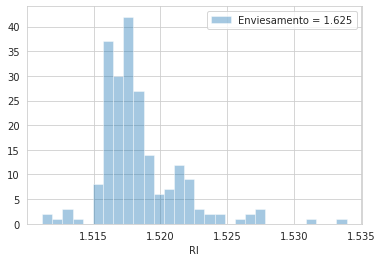

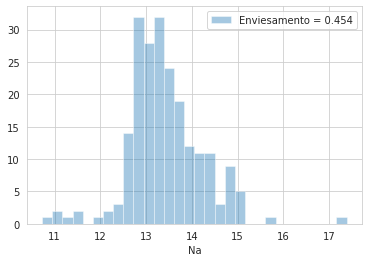

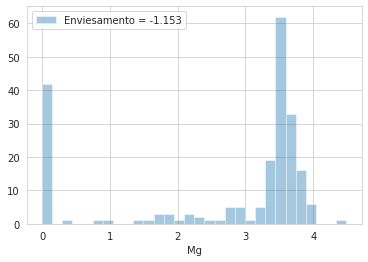

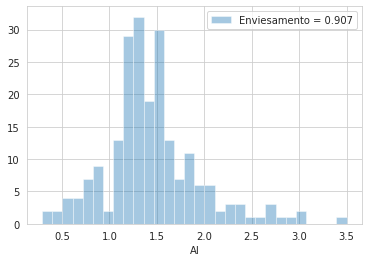

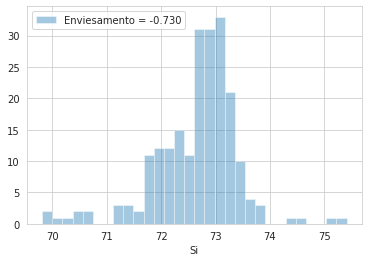

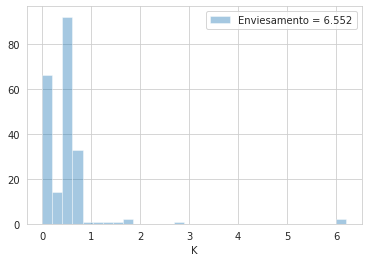

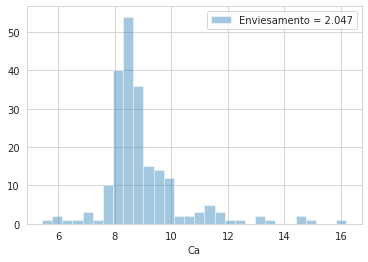

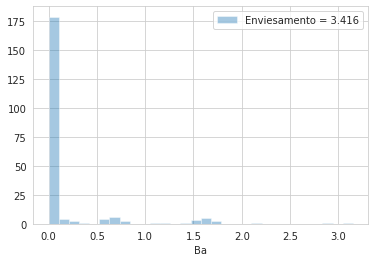

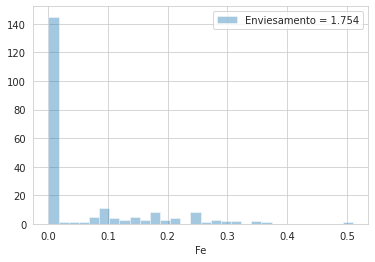

In [ ]:
for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Enviesamento = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

Nenhuma das features é normalmente distribuída. As features **Fe**, **Ba**, **Ca** e **K** exibem os maiores coeficientes de assimetria. Além disso, a distribuição do Potássio (**K**) e do Bário (**Ba**) parece conter muitos outliers. Vamos identificar os índices das observações contendo outliers usando o metódo de Tukey.

In [ ]:
# Detecta observações com mais de um outlier

def outlier_hunt(df):
    outlier_indices = []
    
    # itera sobre as features (colunas)
    for col in df.columns.tolist():
        # primeiro quartil (25%)
        Q1 = np.percentile(df[col], 25)
        
        # terceiro quartil (75%)
        Q3 = np.percentile(df[col],75)
        
        # faixa interquartil
        IQR = Q3 - Q1

        outlier_step = 1.5 * IQR
        
        # Determina uma lista de índices de outliers para coluna de recurso
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # acrescenta os índices discrepantes encontrados para col à lista de índices discrepantes
        outlier_indices.extend(outlier_list_col)
        
    # selecionar observações contendo mais de 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('A base de dados contém %d observações com mais de 2 outliers' %(len(outlier_hunt(df[features]))))   

A base de dados contém 14 observações com mais de 2 outliers


Existem cerca de 14 observações com múltiplos outliers. Isso pode prejudicar a eficiência de nossos algoritmos de aprendizagem. Iremos nos livrar deles nas próximas seções.

Vamos examinar os boxplots para várias distribuições.

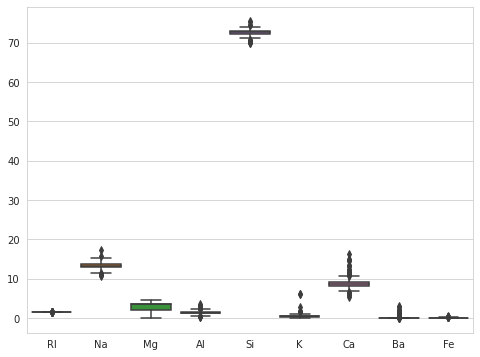

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df[features])
plt.show()



*   **Gráficos Multivariados**


Vamos desenhar agora o pairplot para examinar visualmente a correlação entre as features.

<Figure size 576x576 with 0 Axes>

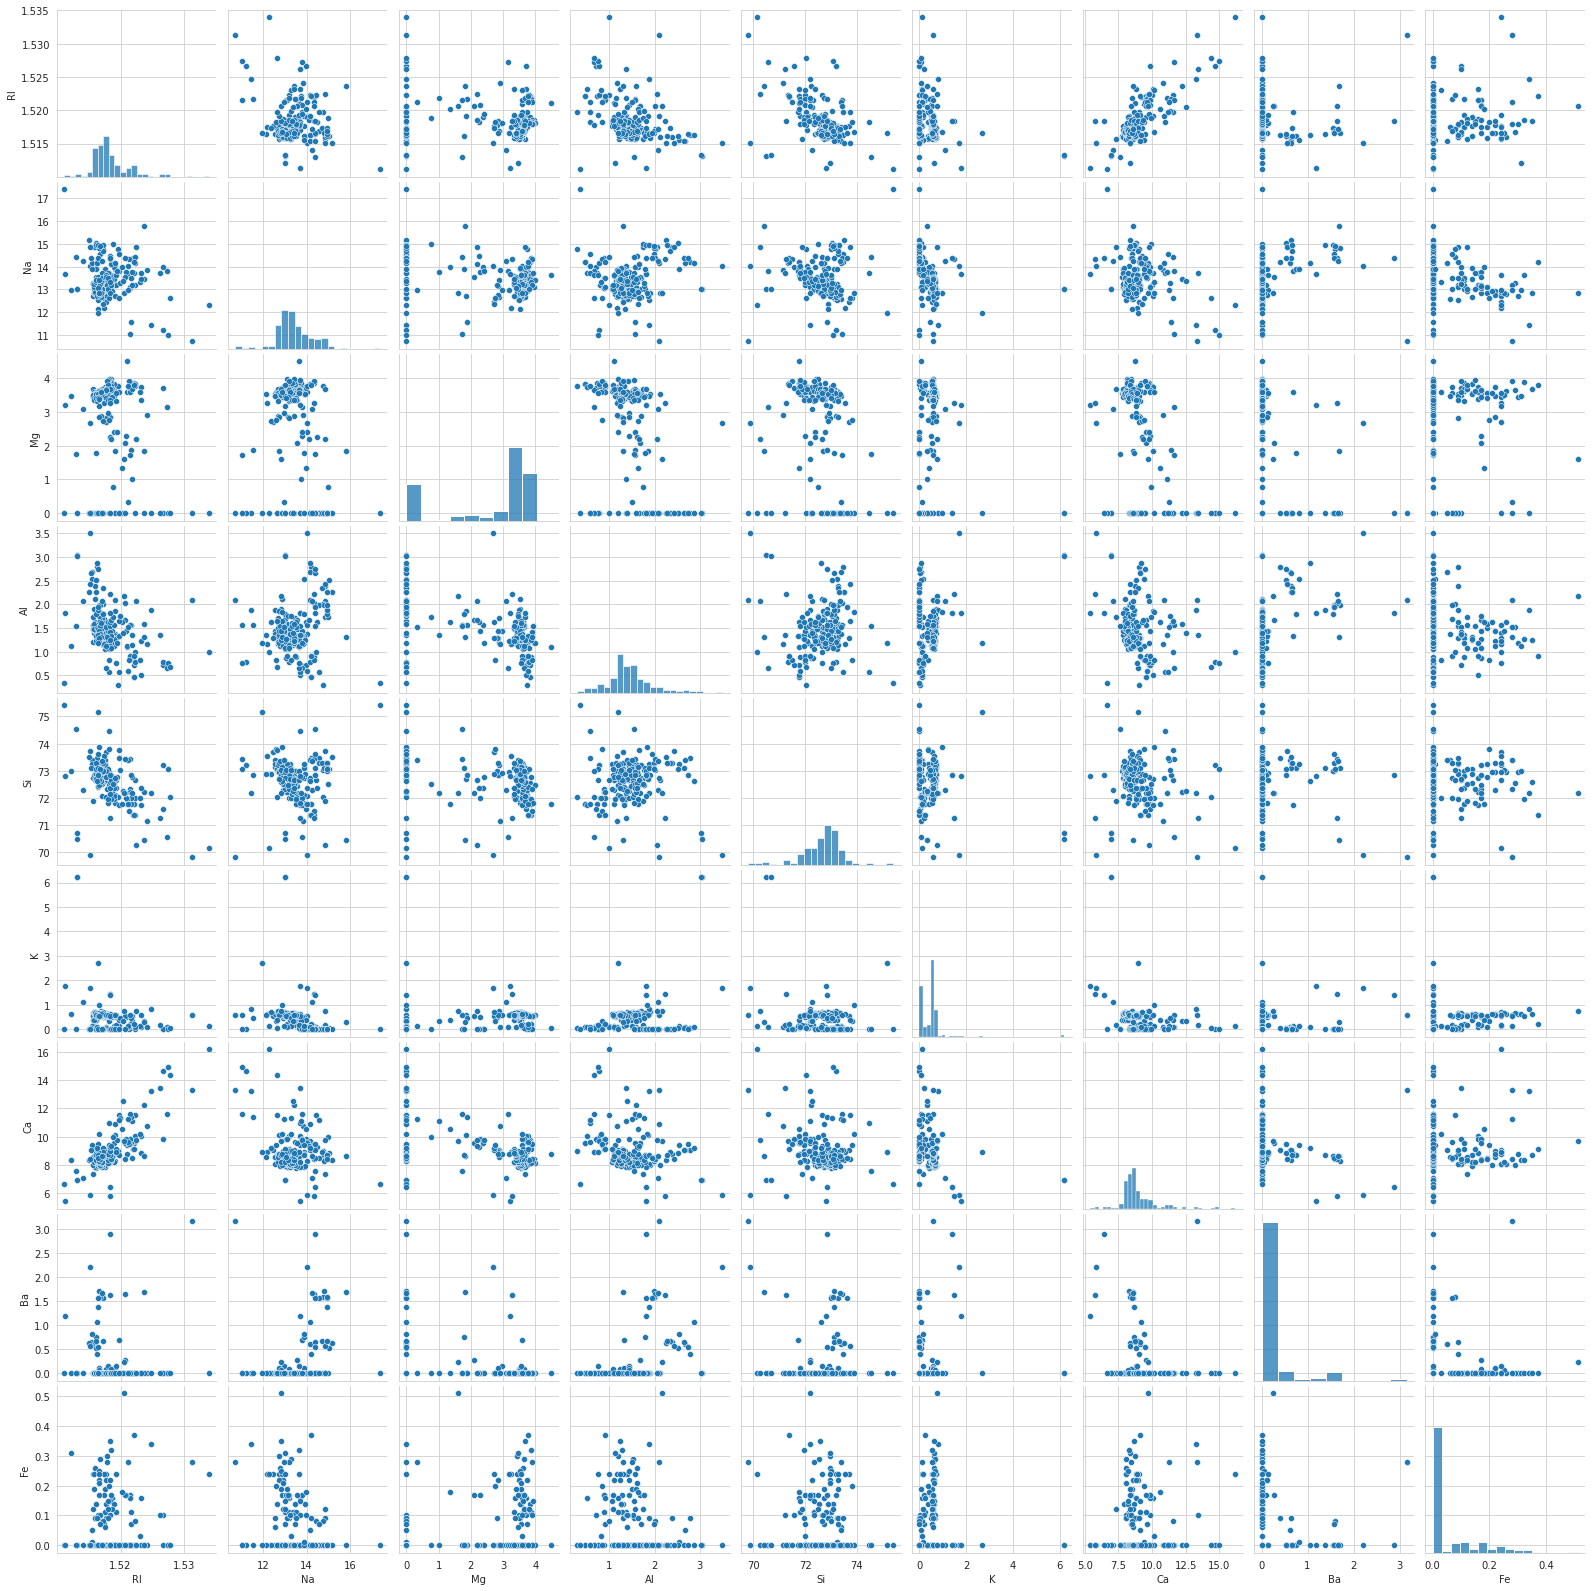

In [ ]:
plt.figure(figsize=(8,8))
sns.pairplot(df[features],palette='coolwarm')
plt.show()

Agora iremos examinar o heatmap das correlações.

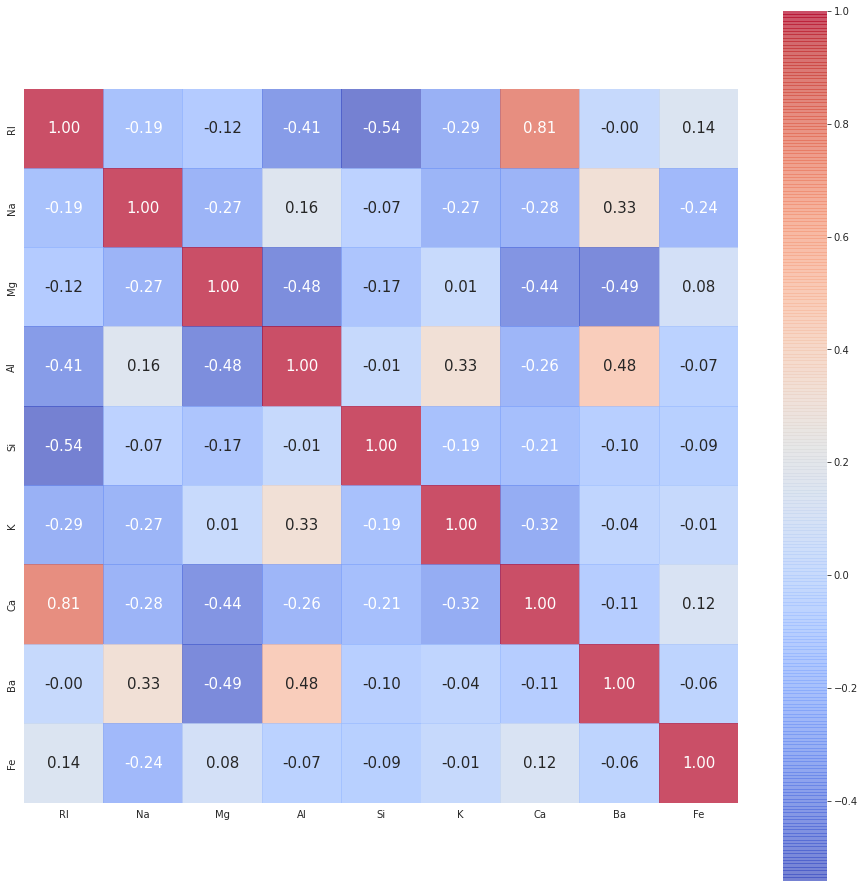

In [ ]:
corr = df[features].corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features, yticklabels= features, alpha = 0.7,   cmap= 'coolwarm')
plt.show()

Parece haver uma forte correlação positiva entre **RI** e **Ca**. Isso pode ser uma dica para realizar a análise do componente principal a fim de descorrelacionar algumas das features de entrada.

## **3) Preparando os dados**

### **Tratamento de correlações entre as features**



Como o classificador ingênuo de Bayes considera que as features são independentes entre si, é necessário observar se essa condição é respeitada entre as features da base utilizada.

Como visto anteriormente, parece haver uma forte correlação positiva entre **RI** e **Ca**. Logo, para mantermos a condição de independência entre as features, iremos fazer a remoção de uma dessas duas features. A feature que escolhemos para remover foi o **Ca**.



In [ ]:
df = df.drop(['Ca'],axis=1)
features = df.columns[:-1].tolist()

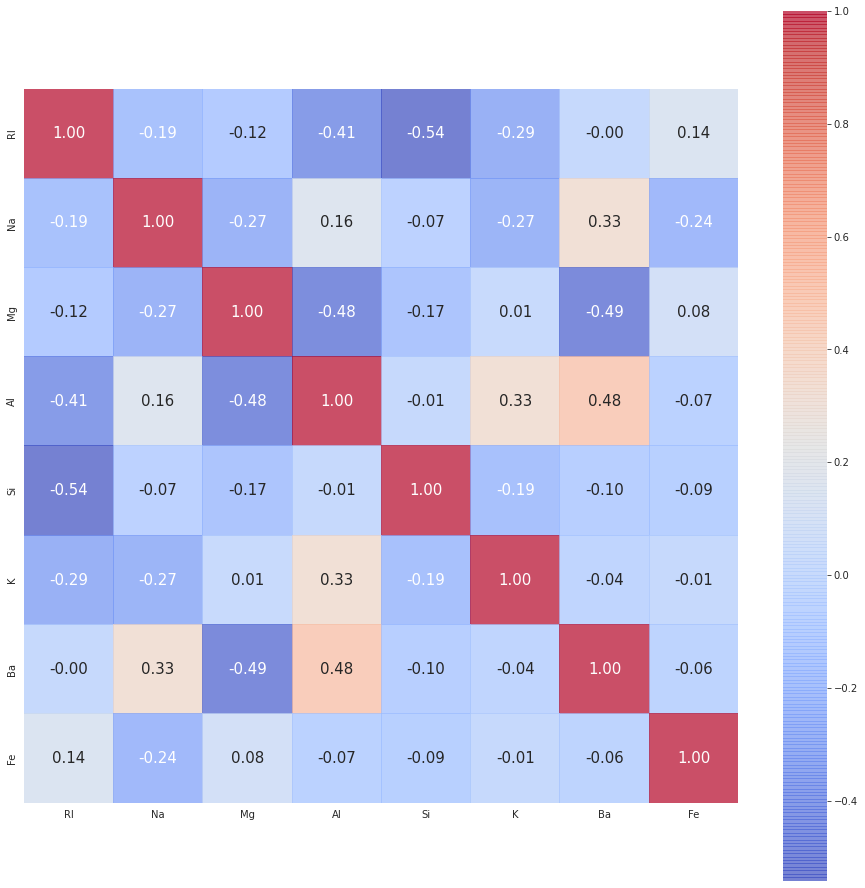

In [ ]:
corr = df[features].corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           xticklabels= features, yticklabels= features, alpha = 0.7,   cmap= 'coolwarm')
plt.show()

### **Limpeza de dados**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ba      214 non-null    float64
 7   Fe      214 non-null    float64
 8   Type    214 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 15.2 KB



Como podemos notar, esta base de dados está limpa, não faltam valores nela.

### **Localizando e removendo os outliers**


Agora, nós iremos remover as observações que contêm múltiplos outliers com a função que criamos na seção anterior.

In [ ]:
outlier_indices = outlier_hunt(df[features])
df = df.drop(outlier_indices).reset_index(drop=True)
print(df.shape)

(206, 9)


A remoção das observações com múltiplos outliers (mais de 2) nos deixou com um total de 206 observações para utilizarmos como base, a remoção da feature **Ca** facilitou o nosso trabalho, pois haviamos detectado anteriormente que existiam 14 observações na nossa base de dados com mais de 2 outilers, mas após essa remoção feita acima nós removemos apenas 8 observações.

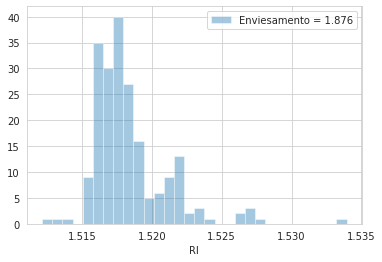

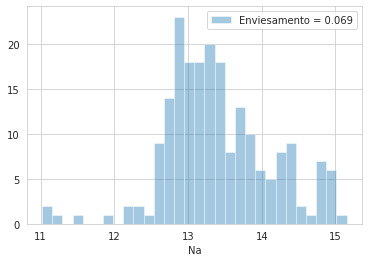

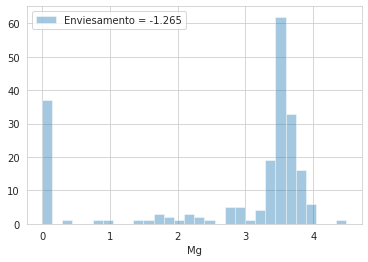

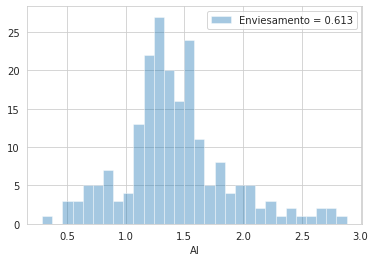

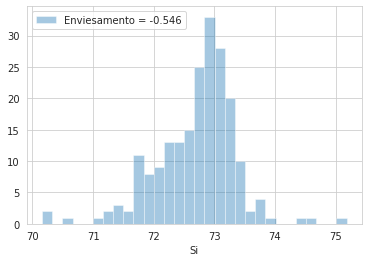

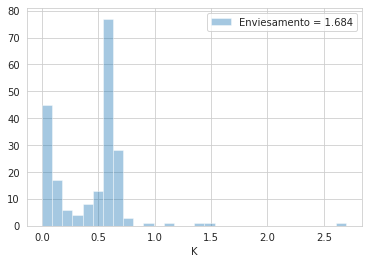

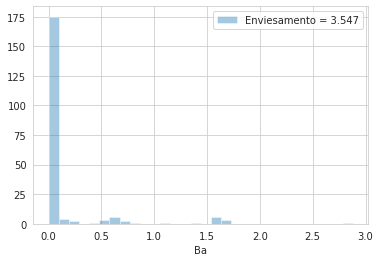

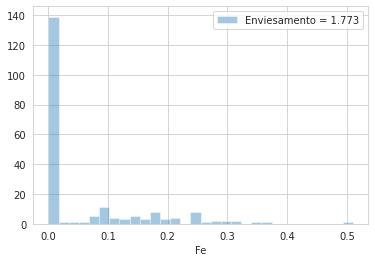

In [ ]:
for feat in features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde=False, label='Enviesamento = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [ ]:
df['Type'].value_counts()

2    74
1    70
7    27
3    17
5    10
6     8
Name: Type, dtype: int64


Vamos agora representar graficamente a distribuição dos tipos de vidro contidos na nossa base de dados.

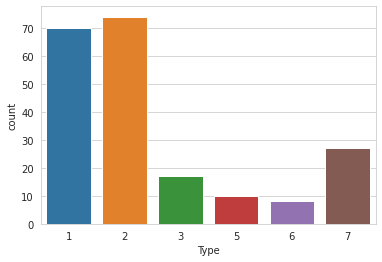

In [ ]:
sns.countplot(df['Type'])
plt.show()

### **Separando o cojunto de dados de validação**



In [ ]:
# Define X como as features e y como as labels
X = df[features] 
y = df['Type'] 

seed = 7
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size , random_state = seed)

### **Transformação de dados**



Vamos examinar se uma transformação Box-Cox pode contribuir para a normalização de alguns recursos. Deve-se enfatizar que todas as transformações devem ser feitas apenas no conjunto de treinamento para evitar espionagem de dados. Caso contrário, a estimativa do erro de teste será tendenciosa.

In [ ]:
features_boxcox = []

for feature in features:
    bc_transformed, _ = boxcox(df[feature]+1)
    features_boxcox.append(bc_transformed)

features_boxcox = np.column_stack(features_boxcox)
df_bc = pd.DataFrame(data=features_boxcox, columns=features)
df_bc['Type'] = df['Type']

In [ ]:
df_bc.describe()

,RI,Na,Mg,Al,Si,K,Ba,Fe,Type
count,2.060000e+02,206.000000,206.000000,206.000000,2.060000e+02,206.000000,206.000000,206.000000,206.000000
mean,7.053954e-04,8.183755,12.182426,0.951429,3.433369e+21,0.330885,0.015175,0.018655,2.699029
std,1.956318e-18,0.351738,6.771859,0.221700,3.673124e+20,0.211039,0.034810,0.027322,2.071102
min,7.053954e-04,7.009812,0.000000,0.261371,2.234315e+21,0.000000,0.000000,0.000000,1.000000
25%,7.053954e-04,7.947754,7.156230,0.850051,3.216031e+21,0.112971,0.000000,0.000000,1.000000
50%,7.053954e-04,8.138303,15.471919,0.938446,3.484741e+21,0.432945,0.000000,0.000000,2.000000
75%,7.053954e-04,8.382578,16.571757,1.063139,3.646741e+21,0.463901,0.000000,0.051139,3.000000
max,7.053954e-04,9.018040,25.579285,1.561866,5.101399e+21,1.261766,0.100811,0.067553,7.000000


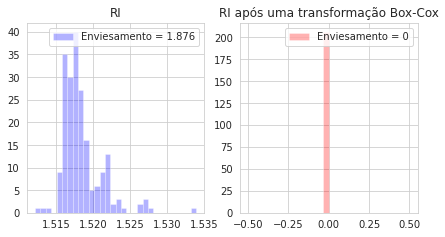

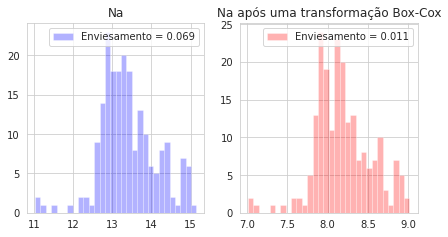

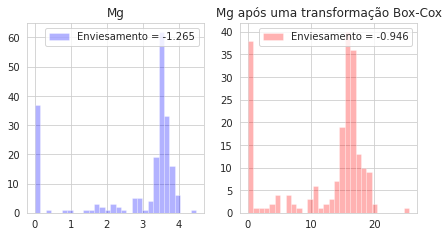

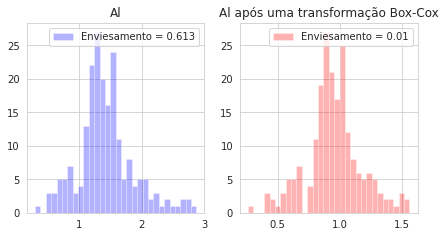

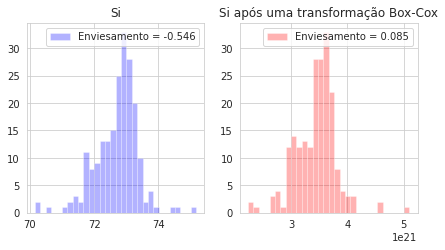

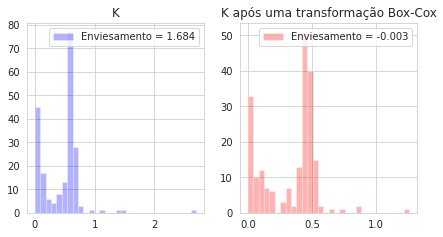

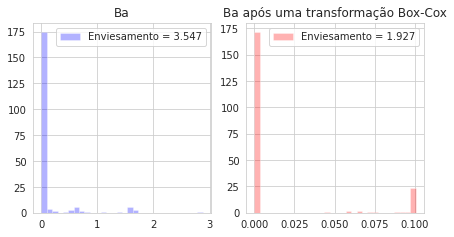

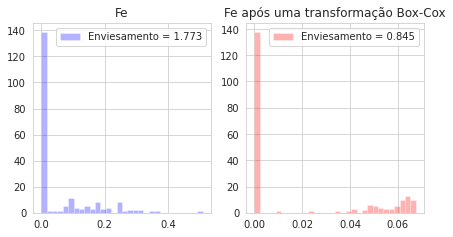

In [ ]:
for feature in features:
    fig, ax = plt.subplots(1,2,figsize=(7,3.5))    
    ax[0].hist(df[feature], color='blue', bins=30, alpha=0.3, label='Enviesamento = %s' %(str(round(df[feature].skew(),3))) )
    ax[0].set_title(str(feature))   
    ax[0].legend(loc=0)
    ax[1].hist(df_bc[feature], color='red', bins=30, alpha=0.3, label='Enviesamento = %s' %(str(round(df_bc[feature].skew(),3))) )
    ax[1].set_title(str(feature)+' após uma transformação Box-Cox')
    ax[1].legend(loc=0)
    plt.show()

In [ ]:
for feature in features:
    delta = np.abs( df_bc[feature].skew() / df[feature].skew() )
    if delta < 1.0 :
        print('A feature %s está menos enviesado após uma transformação Box-Cox' %(feature))
    else:
        print('A feature %s está mais enviesado após uma transformação Box-Cox'  %(feature))

A feature RI está menos enviesado após uma transformação Box-Cox
A feature Na está menos enviesado após uma transformação Box-Cox
A feature Mg está menos enviesado após uma transformação Box-Cox
A feature Al está menos enviesado após uma transformação Box-Cox
A feature Si está menos enviesado após uma transformação Box-Cox
A feature K está menos enviesado após uma transformação Box-Cox
A feature Ba está menos enviesado após uma transformação Box-Cox
A feature Fe está menos enviesado após uma transformação Box-Cox


## **4) Treinando o modelo**

Nessa seção é feito o treinamento e medição de acurácia do classificador de Bayes, será utilizado o algoritmo classificador **GaussianNB**, já que todos elementos do nosso dataset se tratam de valores numéricos flutuantes em uma distribuição normal

In [ ]:
numerical_columns = [column for column in X_test.columns ]
numerical_columns

['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ba', 'Fe']

In [ ]:
#Instanciando o classificador Gaussiano
gaussian_1 = GaussianNB()

#Método fit é responsável por treinar o modelo
gaussian_1.fit(X_train.values,y_train)

#Acurácia do modelo
acc_model_1 = gaussian_1.score(X_test,y_test)

print("Acurácia do modelo 1: {:03.2f}%".format(acc_model_1))

def just_gauss(X_train, y_train):
  gaussian = GaussianNB()
  gaussian.fit(X_train.values,y_train)

  return gaussian.score

Acurácia do modelo 1: 0.67%
